# Expérimentations - GCN for text classification - Dataset R8

Dans ce notebook, nous allons tenter de recoder l'algorithme décrit dans le papier "Graph Convolutional Networks for text classification" et d'effectuer des expériences autour de celui-ci.

Notre objectif sera de classifier correctement des textes, en n'ayant qu'une petite base d'entraînement.

A partir d'un corpus de textes, dont seulement un petit pourcentage est labelisé, nous souhaitons attribuer des classes à tous les documents. Le principe sera de répandre les classes des textes labelisés grâce à un GCN. Pour cela, nous devrons donc représenter nos données sous la forme d'un graphe.

Nous allons donc construire un graphe hétérogène dont les sommets seront des mots (apparaissant dans les documents) et des documents. Les arêtes représenteront des liens entre des mots, ou bien entre mots et documents, mais il n'y a pas d'arêtes entre documents. 

Le graphe contiendra tous les documents du corpus, c'est-à-dire autant le test set que le train set. Néanmoins, seul un petit pourcentage de ces documents disposerons de labels.

Une fois le graphe construit nous pourrons lui appliquer un Graph Convolutional Network (GCN), dans le but de classifier les documents non labelisés. Un GCN est un réseau de neurones qui généralise les convolutions aux graphes, et qui induit des embeddings à chaque noeud en exploitant les features du noeud en question et ceux de ses voisins. Lors de l'entraînement du GCN, les labels des documents sont propagés à travers tout le graphe.

Nous pourrons mesurer les performances de notre modèle en regardant le taux de documents bien classifiés (parmi les documents qui ne disposaient pas de labels avant le GCN).

Nous pourrons enfin tenter diverses expérimentations, notamment :
- Réimplémenter l'expérience consistant à essayer plusieurs pourcentages de données labelisées
- Au lieu d'utiliser le PMI comme poids des arêtes entre deux mots, calculer la similarité cosinus entre les embeddings des mots
    

### Table des matières <a name="up"></a>

* [1 Import des textes](#import)
* [2 Préparation des données](#data-prep)
* [3 Calcul du TFIDF et du PMI](#tfidf-pmi)
* [4 Construction du graphe](#graph)
* [5 Préparation du dataset](#dataset)
* [6 Construction et entraînement du GCN](#gcn)
* [7 Expériences](#exp)

Nous commençons par importer les librairies dont nous aurons besoin.

Parmi celles-ci, plusieurs librairies de NLP, qui nous servirons notamment pour le pré-processing des données, et la tokenization (c'est-à-dire pour séparer les documents en mots). Nous aurons également besoin de la librairie networkx qui permet de gérer les graphes.


In [ ]:
!pip install git+https://github.com/kerighan/convectors
!pip install git+https://github.com/kerighan/textgraph

In [ ]:
!pip install gensim -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.4.0 requires numpy<1.15.0,>=1.8.2, but you have numpy 1.23.0 which is incompatible.
bert-embedding 1.0.1 requires numpy==1.14.6, but you have numpy 1.23.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install scikit-learn -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 16.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.0
    Uninstalling scikit-learn-0.24.0:
      Successfully uninstalled scikit-learn-0.24.0
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.3 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
t

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 17.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 KB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.6.0-py3-none-any.whl size=259930 sha256=192f3a5ad161023de3d4e7b0fec60e9307f99dde2e45509eb4ee59b47602a926
  Stored in directory: /root/.cache/pip/wheels/75/d0/a1/57ea55532e4ff6e3efbec7a851724a8f7a5b073ff648dd4160
  Created wheel for numpy: filename=numpy-1.14.6-cp38-cp38-linux_x86_64.whl size=9740653 sha256=491a76b918ab504eb25a2f1af4e2219ab34411d4a5141a68660d821e49be0d85
  Stored in directory: /root/.cache/pip/wheels/77/81/aa/e309a6725c1cb6f5b37c3c67b74828fd4db0827592ff4a4f85
Successfully built gluonnlp numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling 

In [ ]:
# Math
import numpy as np
import math
import random

# NLP
import gensim
from gensim.models import TfidfModel
from gensim import matutils
from convectors.layers import (Contract, Lemmatize, Phrase, TfIdf, Tokenize)
from bert_embedding import BertEmbedding
from sklearn.metrics.pairwise import cosine_similarity

# Affichage du temps et accès aux données
from tqdm import tqdm
import os

# Structure de données
from scipy.sparse import csc_matrix, lil_matrix, csr_matrix

# Graphes
import networkx as nx
import networkx.algorithms.community as nx_comm
from textgraph.graph import TextGraph

#Visualisation
from matplotlib import pyplot as plt

# 1 Import des textes <a name="import"></a>

[Retour table des matières](#up)

Pour importer les textes de notre dataset, nous avons décidé de reprendre et adapter le code des auteurs du papier, afin d'être certains d'avoir exactement les mêmes données et ainsi pouvoir comparer nos résultats.


Nous créons ainsi plusieurs listes.

    - doc_name_list est la liste de tous les triplets (id, test/train, label) en strings.
    - doc_train_list et doc_test_list contiennent, sous la même forme que la liste précédente, les triplets des test et train set respectivement.
    - doc_content_list est la liste des textes.
    - train_ids est la liste des id d'entrainement.
    - train_ids_str est la même chose, mais sous forme de string avec les ids séparés par des \n
    - shuffle_doc_name_list correspond à doc_name_list, mais mélangé aléatoirement.
    - shuffle_doc_words_list correspond à doc_content_list mais mélangé aléatoirement.
    
Cette partie du code (import des données) est fortement inspirée du [github des auteurs](https://github.com/yao8839836/text_gcn).

In [ ]:
## Définis la proportion du dataset à utiliser, utile pour les expériences
percentage_dataset_used = 0.03

On clone tout d'abord le github des auteurs pour reprendre le même dataset.

In [ ]:
!git clone https://github.com/yao8839836/text_gcn

fatal: destination path 'text_gcn' already exists and is not an empty directory.


Puis on charge les données dans les différentes listes.

In [ ]:
# Dataset auquel on s'interesse
dataset = 'R8'

In [ ]:
# Liste des triplets (id, train/test, label) en strings
doc_name_list = []
doc_train_list = []
doc_test_list = []

f = open(os.path.join('text_gcn', 'data', 'R8.txt'), 'r')
lines = f.readlines()
for i in range(len(lines)):
    if np.random.uniform(0,1) > percentage_dataset_used:
        continue
    doc_name_list.append(lines[i].strip())
    temp = lines[i].split("\t")
    if temp[1].find('test') != -1:
        doc_test_list.append(lines[i].strip())
    elif temp[1].find('train') != -1:
        doc_train_list.append(lines[i].strip())
f.close()

In [ ]:
print(f'doc_name_list ({len(doc_name_list)}): {doc_name_list[:5]}')
print(f'doc_train_list ({len(doc_train_list)}): {doc_train_list[:5]}')
print(f'doc_test_list ({len(doc_test_list)}): {doc_test_list[:5]}')

doc_name_list (199): ['9\ttrain\tearn', '62\ttrain\tacq', '119\ttrain\tacq', '153\ttrain\tacq', '159\ttrain\tacq']
doc_train_list (135): ['9\ttrain\tearn', '62\ttrain\tacq', '119\ttrain\tacq', '153\ttrain\tacq', '159\ttrain\tacq']
doc_test_list (64): ['5506\ttest\tacq', '5551\ttest\tearn', '5585\ttest\tearn', '5709\ttest\tacq', '5738\ttest\tearn']


In [ ]:
# Liste des textes
doc_content_list = []
f = open('text_gcn/data/corpus/' + dataset + '.clean.txt', 'r')
lines = f.readlines()
for line in lines:
    doc_content_list.append(line.strip())
f.close()

In [ ]:
print(f'doc_content_list ({len(doc_content_list)}): \n{doc_content_list[0]}')

doc_content_list (7674): 
champion products approves stock split champion products inc said board directors approved two one stock split common shares shareholders record april company also said board voted recommend shareholders annual meeting april increase authorized capital stock five mln mln shares reuter


In [ ]:
# Liste des ids d'entrainement
train_ids = []
for train_name in doc_train_list:
    train_id = doc_name_list.index(train_name)
    train_ids.append(train_id)
random.shuffle(train_ids)

train_ids_str = '\n'.join(str(index) for index in train_ids)
f = open('text_gcn/data/' + dataset + '.train.index', 'w')
f.write(train_ids_str)
f.close()

# Liste des ids du test set
test_ids = []
for test_name in doc_test_list:
    test_id = doc_name_list.index(test_name)
    test_ids.append(test_id)
random.shuffle(test_ids)

test_ids_str = '\n'.join(str(index) for index in test_ids)
f = open('text_gcn/data/' + dataset + '.test.index', 'w')
f.write(test_ids_str)
f.close()

ids = train_ids + test_ids

In [ ]:
print(f'train_ids ({len(train_ids)}): {train_ids[:5]}')
print(f'test_ids ({len(test_ids)}): {test_ids[:5]}')
print(f'ids ({len(ids)}): {ids[:5]}')

train_ids (135): [117, 57, 33, 104, 126]
test_ids (64): [180, 162, 165, 190, 170]
ids (199): [117, 57, 33, 104, 126]


In [ ]:
# Shuffle de doc_name_list et doc_content_list
shuffle_doc_name_list = []
shuffle_doc_words_list = []
for id in ids:
    shuffle_doc_name_list.append(doc_name_list[int(id)])
    shuffle_doc_words_list.append(doc_content_list[int(id)])
shuffle_doc_name_str = '\n'.join(shuffle_doc_name_list)
shuffle_doc_words_str = '\n'.join(shuffle_doc_words_list)

In [ ]:
print(f'shuffle_doc_name_list ({len(shuffle_doc_name_list)}): {shuffle_doc_name_list[:5]}')
print(f'shuffle_doc_words_list ({len(shuffle_doc_words_list)}): {shuffle_doc_words_list[:5]}')

shuffle_doc_name_list (199): ['4733\ttrain\tacq', '2170\ttrain\tearn', '1346\ttrain\tearn', '4421\ttrain\tearn', '5224\ttrain\tcrude']
shuffle_doc_words_list (199): ['hutchison sees higher payout satisfactory profits hutchison whampoa ltd hk expects satisfactory profits pay higher dividend year chairman li shing said make specific projections company earnings year said firm pay dividend less cents per share proposed four one stock split one four bonus issue paid total dividends dlrs per share last year equal cents per share adjusting bonus share split hutchison operations ranging trading property container terminals earlier reported tax profits billion dlrs billion dlrs total excluded extraordinary gains mln dlrs partly sale stake south china morning post leading english language newspaper compared mln dlrs previous year said expects another mln dlr gain sale remaining shares li said hong kong property market remains strong economy performing better forecast largely export led growth g

# 2 Préparation des données <a name="init"></a>

[Retour table des matières](#up)

Maintenant que nous avons importé les données sous les formes qui nous conviennent, nous devons les préparer.

Nos données sont déjà partiellement préparées, puisque la ponctuation et les caractères spéciaux ont été retirés, et les textes mis en minuscules. 

En particulier, nous tokenizons les données, c'est-à-dire que nous séparons chaque document en liste de mots. Parmi ces mots, nous retirons les stopwords, c'est-à-dire les mots qui apparaissent très souvent et ne porte pas beaucoup de sens. C'est le cas notamment des pronoms, mais aussi de certains verbes comme être, avoir, etc. Il existe des listes de stopwords préfaites. En l'occurrence nous utilisons une librairie qui elle-même utilise une liste de stopwords issue de la librairie NLTK (spécialisée dans le NLP). Enfin, nous lemmatisons les mots, c'est-à-dire que nous les ramenons à leur racine. Par exemple, "thinking" et "thoughts" deviendront "think".

Pour finir, nous retirons les mots qui apparaissent dans plus de 20% des documents. En effet, nous pouvons considérer qu'un mot qui apparaît dans plus de 1 document sur 5 (parmi plusieurs milliers de textes) n'apporte pas beaucoup de sens. Il s'agit de stopwords également.

In [ ]:
def prep(data, no_below=1, no_above=0.2, max_words=100000):
    """
    data: liste de documents
    """

    word_tok = Contract()
    word_tok += Tokenize(stopwords=["en","fr"])
    word_tok += Lemmatize()
    word_tok += Phrase()
    word_tok.verbose = False
    #word_tok += Snowball(lang="french") #stemming
    
    tokens = word_tok(data)
    #print((tokens)) = liste des mots par doc
    
    dictionary = gensim.corpora.Dictionary(tokens)
    #print(dictionary)
    
    #doesn't keep words that appear in less than no_below docs or more than no_above (ratio) docs
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=max_words)
    #print(dictionary) 
    
    return word_tok, dictionary

Nous construisons un dictionnaire de tokens uniques à partir du corpus de documents `doc_content_list`.

In [ ]:
word_tok, dictionary = prep(doc_content_list, 0.2)

In [ ]:
print(dictionary)

Dictionary<7263 unique tokens: ['also', 'annual', 'approved', 'approves', 'april']...>


# 3 Calcul du TFIDF et du PMI<a name="dico"></a>

[Retour table des matières](#up)

Nous calculons maintenant le score TFIDF, qui nous servira pour les poids des arêtes entre les mots et documents.

Le score TFIDF traduit l'idée qu'un mot qui apparait beaucoup dans un document mais assez peu dans le corpus est probablement un mot important relativement au document. Un mot qui apparait très peu dans un texte est assez logiquement peu important (sauf s'il n'apparait presque jamais dans le reste du corpus !). Enfin un mot qui apparait souvent dans le document mais qui apparait également souvent dans le corpus n'est pas très important. Il s'agit également d'une forme de stopwords.

Le score TFIDF est donc une mesure statistique basée sur la fréquence des mots.

Il se calcule selon la formule qui suit :

$$tf(t,d) = \frac{f_d(t)}{max_{w \in d} f_d(w)} $$

$$idf(t, D) = ln(\frac{|D|}{|\{d \in D : t \in d\} |}) $$

$$tfidf(t, d, D) = tf(t, d) \times idf(t, D) $$

avec $f_d(t)$ la fréquence du terme t dans le document d, et D le corpus de documents.

In [ ]:
def compute_tfidf(data, dictionary, word_tok, option=1):
    """

    Retourne:
        - TFIDF (matrice sparse): score TF-IDF entre ?
        - tokenized_data (pd.Series): liste des mots par document
        - tokenized_data_idx (list): liste des indices des mots dans dictionary par document
        - vocab (np.array): ensemble des mots 
    """
    tokenized_data = word_tok(data)
    
    tokenized_data_idx = []
    for i in range(len(data)):
        tokenized_data_idx.append(dictionary.doc2idx(tokenized_data[i]))
    
    if option : #1
        corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
        tfidf = TfidfModel(corpus) #fit
        X = tfidf[corpus] #transform
        TFIDF = matutils.corpus2csc(X,num_docs=len(X)).T
    
        vocab = list(dictionary.token2id.keys())
        
    else: #0
        vectorizer = TfIdf(
            min_df=1,
            max_df=.5,
            max_features=None,
            verbose=False)

        TFIDF = vectorizer(tokenized_data)
        vocab = vectorizer.vectorizer.get_feature_names_out()
        
    #Version dense et datafrmame
    #mat_dense = TFIDF.toarray()
    #df_tfidf = pd.DataFrame(mat_dense, columns=vocab)    
    
    return TFIDF, tokenized_data, tokenized_data_idx, vocab

In [ ]:
TFIDF, tokenized_data, tokenized_data_idx, vocab = compute_tfidf(doc_content_list, dictionary, word_tok, 0)

In [ ]:
TFIDF.shape

(7674, 7275)

In [ ]:
vocab.shape

(7275,)

In [ ]:
tokenized_data

0       [champion, product, approves, stock, split, ch...
1       [computer, terminal, system, complete, sale, c...
2       [inc, year, net, shr, ct, vs, dlrs, net, vs, a...
3       [international, inc, nd, qtr, jan, oper, shr, ...
4       [brown, forman, inc, th qtr, net, shr, one, dl...
                              ...                        
7669    [balladur, maintenance, louvre accord, french,...
7670    [philippin, trade, gap, widens, january, augus...
7671    [iran, soviet, union, swap, crud, refined, pro...
7672    [chase, corp, make, offer, entregrowth, chase,...
7673    [japan, india, conference, cut, gulf, war, ris...
Length: 7674, dtype: object

Nous calculons désormais le PMI (Pointwise Mutual Information). Cela nous servira pour les poids des arêtes entre deux mots. Le PMI mesure à quel point 2 mots sont susceptibles d'apparaitre ensemble. Il s'agit donc d'une mesure de la co-occurrence. L'hypothèse faite est que deux mots qui apparaissent souvent ensemble sont susceptibles d'avoir un sens proche.

Pour calculer le PMI, il faut faire glisser une fenêtre sur chacun des textes. La taille de cette fenêtre est un hyper-paramètre à choisir.

En parcourant les documents, nous compterons : 

    - Le nombre total de fenêtres : #W
    - Le nombre de fenêtres qui contiennent le mot i, pour chaque mot i : #W(i)
    - Le nombre de fenêtres qui contiennent 2 mots i et j : #W(i,j)
    
Finalement, le PMI se calcule comme suit : 

$$ p(i, j) = \frac{\#W(i,j)}{\#W} $$

$$ p(i) = \frac{\#W(i)}{\#W} $$

$$ PMI(i, j) = log \frac{p(i,j)}{p(i)p(j)} $$

Les cellules qui suivent nous serviront à décomposer le calcul du PMI en plusieurs fonctions.


In [ ]:
def ordered_word_pair(a, b):
    if a > b:
        return b, a
    else:
        return a, b
        
def update_word_and_word_pair_occurrence(q, W_i, W_ij):
    '''
    Traitement des mots de une fenêtre
    
    q : set d'indices de mots
    '''
    # On utilise un set pour avoir chaque mot une seule fois
    # L'ordre n'est pas important
    unique_q = list(set(q))

    # On retire les mots qui n'apparaissent pas dans le dictionnaire
    # qui sont les mots dont la valeur est -1
    if -1 in unique_q:
        unique_q.remove(-1)

    for w in unique_q:
        # Mise a jour du nombre de fenetres ou apparait chaque mot
        try:
            W_i[w] += 1
        except:
            W_i[w] = 1 # Si la valeur n'existe pas encore

    for i in range(len(unique_q)):
        # Mise a jour du nombre de fenetres ou apparait chaque paire
        for j in range(i+1, len(unique_q)):
            # Pour chaque mot j après i 
            word1 = unique_q[i]
            word2 = unique_q[j]
            # On ne veut update que un coté de la matrice
            word1, word2 = ordered_word_pair(word1, word2)
            try:
                W_ij[word1, word2] += 1
            except:
                W_ij[word1, word2] = 1
    return W_i, W_ij

In [ ]:
def compute_pmi(tokenized_data_idx, window_size=10, threshold=0.1, min_count=2, normalize=True):
    """
    Retourne:
        - PMI (dict): (paire de mots representes par leurs indices): pmi
    """
    W = 0 #compte des fenêtres

    W_ij = dict()
    W_i = dict()

    #tokenized_data = liste des mots pour chaque doc
    for words in tqdm(tokenized_data_idx):
        #Pour chaque document, calcul de toutes les fréquences Wi Wij
        #words = liste des indices des mots de 1 doc

        #Initialisation de la fenêtre
        q = []
        for i in range(min(window_size, len(words))):
            #On ajoute à la queue les indices des mots de la fenetre
            #en partant du début du doc
            q.append(words[i])
        #Update du nb de fenetres
        W+=1
        #Update de W(i) et W(i,j)
        W_i, W_ij = update_word_and_word_pair_occurrence(q, W_i, W_ij)

        next_word_idx = window_size
        #Tant qu'on a pas fini le doc, on décale la fenêtre
        while next_word_idx<len(words):
            #On décale la fenêtre
            #En enlevant le premier mot
            q.pop(0)
            #Et en ajoutant le mot suivant (son indice)
            q.append(words[next_word_idx])
            next_word_idx+=1
            W+=1
            W_i, W_ij = update_word_and_word_pair_occurrence(q, W_i, W_ij)  
    
    PMI = dict()
    #Pour chaque mot qui apparaissent ensemble
    for (i,j), Wij in tqdm(W_ij.items()):
        #On ne garde pas les couple qui apparaissent trop peu
        if Wij < min_count:
            continue
        #word freq
        Wi = W_i[i]
        Wj = W_i[j]
        pij = Wij/W
        pi = Wi/W
        pj = Wj/W

        pmi=math.log(pij/(pi*pj))

        #Normalisation du PMI
        if normalize:
            pmi = pmi/(-math.log(pij))
        if pmi > threshold:
            PMI[i,j]=pmi
    return PMI

In [ ]:
import pickle 

def load_pickle(filename, dir):
    completeName = os.path.join(f"./{dir}/{filename}")
    with open(completeName, 'rb') as pkl_file:
        data = pickle.load(pkl_file)
    return data

def save_as_pickle(filename, dir, data):
    completeName = os.path.join(f"./{dir}/{filename}")
    with open(completeName, 'wb') as output:
        pickle.dump(data, output)

Comme expliqué précédemment, les liens entre 2 mots sont leur score PMI. Afin de juger de l'efficacité de ce score, nous avons souhaité essayer une autre mesure de ce lien.

Nous allons donc attribuer à chaque mot du vocablaire un embedding, en utilisant un modèle pré entrainé. Ainsi, nous pourrons calculer la similarité cosinus entre deux mots (donc entre leurs deux vecteurs), et utiliser ce nouveau score comme poids d'une arête entre deux mots.

In [ ]:
def generate_embeddings(vocab):
    try:
        wv = load_pickle(dir = "embeddings", filename = "wordvectors")
    except FileNotFoundError:
         wv = {}
    new_words = []
    for word in vocab:
        if word in wv or word in new_words:
            continue
        new_words.append(word)
    new_words = list(set(new_words))
    bert_embedding = BertEmbedding()
    result = bert_embedding(new_words)
    for pair in result:
        wv[pair[0][0]] = pair[1][0]
    save_as_pickle("wordvectors", "embeddings", wv)
    return wv


def compute_CS(vocab, threshold = .5):
    wv = generate_embeddings(vocab)
    try:
        CS = load_pickle(dir = "embeddings", filename = "CS.pkl")
        return CS
    except FileNotFoundError:
         CS = {}
    for i in tqdm(range(len(vocab)-1)):
        word1 = vocab[i].split()[0]
        for j in range(i+1, len(vocab)):
            if (i,j) in CS.keys():
                continue
            word2 = vocab[j].split()[0]
            try:
                similarity = cosine_similarity(wv[word1].reshape(1, -1), wv[word2].reshape(1, -1))
                if similarity[0][0] > threshold:
                    CS[word1, word2] = similarity
            except KeyError:
                pass
    save_as_pickle("CS.pkl", "embeddings", CS)
    return CS

In [ ]:
PMI = compute_pmi(tokenized_data_idx, window_size=10, threshold=0.2, min_count=20, normalize=True)

100%|██████████| 992269/992269 [00:00<00:00, 1972811.11it/s]


# 4 Construction du graphe <a name="tfidf"></a>

[Retour table des matières](#up)

Nous allons maintenant construire le graphe.

Pour cela, nous commençons par créer un sommet par mot du vocabulaire, et une arête par couple de mots (qui ont un score PMI supérieur à un certain seuil) avec comme poids le score PMI.

Ensuite nous créons une arête par couple (document, mot)

In [ ]:
def create_graph(PMI, TFIDF, vocab):
    nodes = set()
    edges = []
    
    #aretes entre les mots
    #list_pmi = list(PMI.items())
    for (u,v), w in PMI.items():
        mot_u = u
        mot_v = v
        edges.append((mot_u,mot_v,w))
        nodes.add(mot_u)
        nodes.add(mot_v)
    
    l = len(edges)
        
    #aretes entre mots et doc
    rows, cols = TFIDF.nonzero()
    for r, c in zip(rows, cols):
        #r = doc car ils sont sur les lignes
        #c = mot car sur les colonnes
        mot = vocab[c]
        if mot not in nodes:
            continue
        triplet = (r, mot, TFIDF[r,c])
        edges.append(triplet)  
        
    l1 = len(edges)

    #construction du graphe
    G = nx.Graph()
    G.add_nodes_from(range(TFIDF.shape[0])) # 1 noeud par doc (idx)
    G.add_weighted_edges_from(edges)

    #Ajout des boucles
    for node in G.nodes:
        G.add_edge(node, node, weight=1)
    
    return G

In [ ]:
def build_graph(data,
                no_below=1,
                no_above=0.2,
                max_words=100000,
                window_size=20, # param du papier
                pmi_threshold=0.2,
                min_count=21,
                normalize=True, 
                method = "PMI"):
    
    word_tok, dictionary = prep(data, no_below, no_above)
    
    TFIDF, tokenized_data, tokenized_data_idx, vocab = compute_tfidf(data, dictionary, word_tok, 0)
    
    n_docs, n_words = TFIDF.shape
    
    if method == "PMI":
        PMI = compute_pmi(tokenized_data , window_size, pmi_threshold, min_count, normalize)
        G = create_graph(PMI, TFIDF, vocab)
    if method == "CS":
        CS = load_pickle(dir = "embeddings", filename = "CS.pkl") #compute_CS(vocab)
        G = create_graph(CS, TFIDF, vocab)
    
    return G

La fonction suivante permet d'obtenir la matrice d'adjacence normalisée, qui sera donnée en entrée du GCN.

In [ ]:
def get_A_hat(G):
    A = nx.to_numpy_matrix(G, weight="weight")
    A = A + np.eye(G.number_of_nodes())
    degrees = []
    for d in G.degree(weight=None):
        if d == 0:
            degrees.append(0)
        else:
            degrees.append(d[1]**(-0.5))
    degrees = np.diag(degrees)
    A_hat = degrees@A@degrees

    return A_hat

On construit une version du graphe avec le PMI et une autre avec la similarité cosinus.

In [ ]:
G = build_graph(doc_content_list)
A_hat = get_A_hat(G)

In [ ]:
G_CS = build_graph(doc_content_list, method = "CS")
A_hat_CS = get_A_hat(G_CS)

# 5 Preparation du dataset <a name="dataset"></a>

[Retour table des matières](#up)

Dans cette section, on implémente une fonction permettant de faire varier la proportion des données labellisées dans le jeu d'entraînement.

In [ ]:
classes = list(set([row.split('\t')[2] for row in doc_name_list]))
num_classes = len(classes)

class2label = {class_name: i for i, class_name in enumerate(classes)}

In [ ]:
class2label

{'money-fx': 0,
 'crude': 1,
 'acq': 2,
 'trade': 3,
 'earn': 4,
 'ship': 5,
 'interest': 6}

In [ ]:
def prepare_dataset(train_list, train_content, labeled_data_size):

    size = int(labeled_data_size * len(train_ids))
    train_subset_ids = []
    train_subset_labels = []
    for i in range(size):
        id, _, class_name = train_list[i].split('\t')
        train_subset_ids.append(int(id))
        train_subset_labels.append(class2label[class_name])
    
    train_subset_ids = np.array(train_subset_ids)
    train_subset_labels = np.array(train_subset_labels)
    train_subset_content = np.array(train_content[:size])
    
    return train_subset_ids, train_subset_labels, train_subset_content

In [ ]:
# Shuffle de doc_name_list et doc_content_list
shuffle_doc_train_list = []
shuffle_doc_train_content_list = []
for id in train_ids:
    shuffle_doc_train_list.append(doc_train_list[int(id)])
    shuffle_doc_train_content_list.append(doc_content_list[int(id)])

In [ ]:
train_subset_ids, train_subset_labels, train_subset_content = prepare_dataset(shuffle_doc_train_list, shuffle_doc_train_content_list, 0.2)

In [ ]:
test_ids = np.array([int(row.split('\t')[0]) for row in doc_test_list])
test_labels = np.array([class2label[row.split('\t')[2]] for row in doc_test_list])

# 6 Construction et entrainement du GCN  <a name="gcn"></a>

[Retour table des matières](#up)

Enfin, nous implémentons une classe GCN.

In [ ]:
hidden_size_1 = 200
hidden_size_2 = 200
start_epoch=0
num_epochs=200
lr=0.02 
#model_no = 0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class gcn(nn.Module):
    def __init__(self, X_size, A_hat, num_classes, bias=True): # X_size = num features
        super(gcn, self).__init__()
        self.A_hat = torch.tensor(A_hat, requires_grad=False).float()

        self.weight = nn.parameter.Parameter(torch.FloatTensor(X_size, hidden_size_1))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        self.drop1 = nn.Dropout(p = 0.5)
        
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(hidden_size_1, hidden_size_2))
        var2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,var2)
        self.drop2 = nn.Dropout(p = 0.5)

        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(hidden_size_1))
            self.bias.data.normal_(0,var)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(hidden_size_2))
            self.bias2.data.normal_(0,var2)
        else:
            self.register_parameter("bias", None)
            
        self.fc1 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, X): ### 2-layer GCN architecture

        # 1st layer
        X = torch.mm(X, self.weight)
        if self.bias is not None:
            X = (X + self.bias)
        X = F.relu(torch.mm(self.A_hat, X))
        X = self.drop1(X)
        
        # 2nd layer
        X = torch.mm(X, self.weight2)
        if self.bias2 is not None:
            X = (X + self.bias2)
        X = F.relu(torch.mm(self.A_hat, X))
        X = self.drop2(X)
        return self.fc1(X) # Shape: (num_nodes, num_classes=8)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import os


def evaluate(output, true_labels):

    # Perform softmax and get predicted label
    _, pred_labels = output.max(1) 
    pred_labels = pred_labels.numpy()

    # Compute accuracy score
    acc_score = sum([(e) for e in true_labels] == pred_labels)/len(true_labels)

    return acc_score


def train(G, A_hat, selected, labels_selected, not_selected, labels_not_selected, num_classes, labeled_data_size, method = "PMI", verbose = False):
    """
    f: torch tensor input of GCN (Identity matrix)
    X: input of GCN (Identity matrix)
    A_hat: transformed adjacency matrix A
    selected: indexes of selected labelled nodes for training
    not_selected: indexes of not-selected nodes for inference/testing
    labels_selected: labels of selected labelled nodes for training
    labels_not_selected: labels of not-selected labelled nodes for inference/testing
    """
    

    # Input of GCN
    n_nodes = G.number_of_nodes()
    X = np.eye(n_nodes) # Feature matrix, is the identity matrix at the beginning
    f = torch.from_numpy(X).float() 

    # Initialization of GCN
    net = gcn(A_hat.shape[0], A_hat, num_classes=num_classes)

    # Training params
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    #scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100, 150, 200], gamma=0.75)

    start_epoch, best_pred = 0, 0
    losses_per_epoch, evaluation_trained, evaluation_untrained = [], [], []

    net.train()

    # For each epoch...
    for e in range(start_epoch, num_epochs):
        optimizer.zero_grad()

        # Forward pass
        output = net(f)
        
        # Compute loss on training labeled set
        loss = criterion(output[selected], torch.tensor(labels_selected).long())
        if verbose:
            print(f'{e} {loss.item()}')
        losses_per_epoch.append(loss.item())

        # Backpropagation
        loss.backward()

        # Parameter update
        optimizer.step()
        
        ### Evaluate other untrained nodes and check accuracy of labelling
        net.eval()
        with torch.no_grad():
            out = net(f)
            trained_accuracy = evaluate(out[selected], labels_selected)
            untrained_accuracy = evaluate(out[not_selected], labels_not_selected)
        evaluation_trained.append((e, trained_accuracy))
        evaluation_untrained.append((e, untrained_accuracy))

        if verbose: 
            print("[Epoch", e, "]: Evaluation accuracy of trained nodes:", trained_accuracy)
            print("[Epoch", e, "]: Evaluation accuracy of test nodes:", untrained_accuracy)
    
        net.train()
        if untrained_accuracy > best_pred:
            best_pred = untrained_accuracy
            torch.save({
                'epoch': e + 1,\
                'state_dict': net.state_dict(),\
                'best_acc': untrained_accuracy,\
                'optimizer' : optimizer.state_dict(),\
                #'scheduler' : scheduler.state_dict(),\
            }, os.path.join("save/" ,\
            "test_model_best_%d.pth.tar" % labeled_data_size))
        ## Don't stop before epoch 50 to prevent slow starts
       
        if e > 50:
            stop_acc_threshold = np.mean([acc[1] for acc in evaluation_untrained[-10:]])
            if stop_acc_threshold > evaluation_untrained[-1][1]: 
                break
        #scheduler.step()

    # Save
    save_as_pickle(filename=f'loss_model_{labeled_data_size}_{method}_n2.pkl', dir='save', data=losses_per_epoch)
    save_as_pickle(filename=f'eval_train_model_{labeled_data_size}_{method}_n2.pkl', dir='save', data=evaluation_trained)
    save_as_pickle(filename=f'eval_test_model_{labeled_data_size}_{method}_n2.pkl', dir='save', data=evaluation_untrained)
    
    return output.max(1)[1], losses_per_epoch, evaluation_trained, evaluation_untrained 

# 7 Expériences <a name="exp"></a>

[Retour table des matières](#up)

## Experiences sur la part de données labellisées

In [ ]:
for labeled_data_size in np.arange(1, 40, 2)/100: #[0.01, 0.05, 0.1, 0.2]:
    print("Training", labeled_data_size)
    train_subset_ids, train_subset_labels, _ = prepare_dataset(shuffle_doc_train_list, shuffle_doc_train_content_list, labeled_data_size)
    _,_,_,evaluation_untrained = train(G, A_hat, selected=train_subset_ids, labels_selected=train_subset_labels, not_selected=test_ids, labels_not_selected=test_labels, num_classes=8, labeled_data_size=labeled_data_size)
    print("Untrained accuracy :", evaluation_untrained[-1])

Training 0.01
Untrained accuracy : (87, 0.7217907720420284)
Training 0.03
Untrained accuracy : (80, 0.7272727272727273)
Training 0.05
Untrained accuracy : (95, 0.7624486066697121)
Training 0.07
Untrained accuracy : (89, 0.7597076290543627)
Training 0.09
Untrained accuracy : (99, 0.7674737322978529)
Training 0.11
Untrained accuracy : (93, 0.7693010507080859)
Training 0.13
Untrained accuracy : (91, 0.7802649611694837)
Training 0.15
Untrained accuracy : (91, 0.7820922795797167)
Training 0.17
Untrained accuracy : (95, 0.7921425308359982)
Training 0.19
Untrained accuracy : (87, 0.7962539972590224)
Training 0.21
Untrained accuracy : (108, 0.7793513019643673)
Training 0.23
Untrained accuracy : (81, 0.7857469164001827)
Training 0.25
Untrained accuracy : (91, 0.7894015532206486)
Training 0.27
Untrained accuracy : (97, 0.7884878940155322)
Training 0.29
Untrained accuracy : (87, 0.789858382823207)
Training 0.31
Untrained accuracy : (110, 0.7884878940155322)
Training 0.33
Untrained accuracy : (100

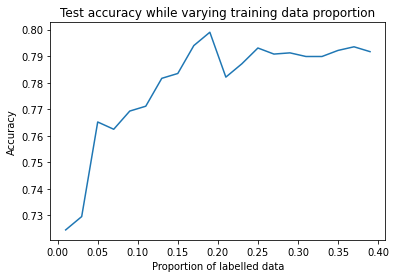

In [ ]:
untrained_accuracy_by_labeled_size = []
for labeled_data_size in np.arange(1, 40, 2)/100:
    untrained_accuracy = load_pickle(filename=f'eval_test_model_{labeled_data_size}_PMI.pkl', dir='save')
    untrained_accuracy = [acc[1] for acc in untrained_accuracy]
    untrained_accuracy_by_labeled_size.append(max(untrained_accuracy))
    
ax = plt.plot(np.arange(1, 40, 2)/100, untrained_accuracy_by_labeled_size)
plt.title("Test accuracy while varying training data proportion")
plt.xlabel("Proportion of labelled data")
plt.ylabel("Accuracy");


## Expériences sur la part de données labellisées et comparaison entre cosine similarity et PMI

In [ ]:
for labeled_data_size in np.arange(1, 40, 2)/100: #[0.01, 0.05, 0.1, 0.2]:
    print("Training", labeled_data_size)
    train_subset_ids, train_subset_labels, _ = prepare_dataset(shuffle_doc_train_list, shuffle_doc_train_content_list, labeled_data_size)
    _,_,_,evaluation_untrained = train(G_CS, A_hat_CS, selected=train_subset_ids, labels_selected=train_subset_labels, not_selected=test_ids, labels_not_selected=test_labels, num_classes=8, labeled_data_size=labeled_data_size, method = "CS")
    print("Untrained accuracy :", evaluation_untrained[-1])

Training 0.01
Untrained accuracy : (74, 0.6870717222476016)
Training 0.03
Untrained accuracy : (74, 0.7153951576062129)
Training 0.05
Untrained accuracy : (68, 0.7121973503883051)
Training 0.07
Untrained accuracy : (73, 0.6966651439013248)
Training 0.09
Untrained accuracy : (86, 0.698949291914116)
Training 0.11
Untrained accuracy : (91, 0.702603928734582)
Training 0.13
Untrained accuracy : (82, 0.7039744175422568)
Training 0.15
Untrained accuracy : (75, 0.6930105070808589)
Training 0.17
Untrained accuracy : (151, 0.7450890817724989)
Training 0.19
Untrained accuracy : (67, 0.6834170854271356)
Training 0.21
Untrained accuracy : (97, 0.7268158976701691)
Training 0.23
Untrained accuracy : (80, 0.7103700319780721)
Training 0.25
Untrained accuracy : (84, 0.7071722247601645)
Training 0.27
Untrained accuracy : (95, 0.7181361352215624)
Training 0.29
Untrained accuracy : (83, 0.7172224760164458)
Training 0.31
Untrained accuracy : (81, 0.7076290543627227)
Training 0.33
Untrained accuracy : (93, 0

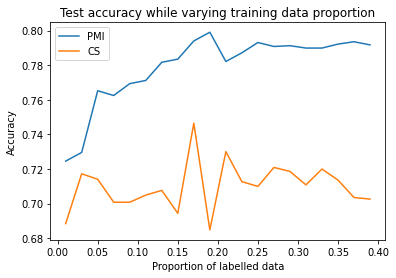

In [ ]:
untrained_accuracy_by_labeled_size_CS = []
untrained_accuracy_by_labeled_size = []
for labeled_data_size in np.arange(1, 40, 2)/100:
    untrained_accuracy_CS = load_pickle(filename=f'eval_test_model_{labeled_data_size}_CS.pkl', dir='save')
    untrained_accuracy_CS = [acc[1] for acc in untrained_accuracy_CS]
    untrained_accuracy_by_labeled_size_CS.append(max(untrained_accuracy_CS))
    untrained_accuracy = load_pickle(filename=f'eval_test_model_{labeled_data_size}_PMI.pkl', dir='save')
    untrained_accuracy = [acc[1] for acc in untrained_accuracy]
    untrained_accuracy_by_labeled_size.append(max(untrained_accuracy))
    
plt.plot(np.arange(1, 40, 2)/100, untrained_accuracy_by_labeled_size, label = "PMI")
plt.plot(np.arange(1, 40, 2) /100, untrained_accuracy_by_labeled_size_CS, label = "CS")
plt.legend()
plt.title("Test accuracy while varying training data proportion")
plt.xlabel("Proportion of labelled data")
plt.ylabel("Accuracy")
plt.show();

## Expériences sur la part de données labélisée et comparaison entre cosine similarity et PI avec un dataset de seulement 10%

In [ ]:
for labeled_data_size in np.arange(1, 15, 2)/100: #[0.01, 0.05, 0.1, 0.2]:
    print("Training", labeled_data_size)
    train_subset_ids, train_subset_labels, _ = prepare_dataset(shuffle_doc_train_list, shuffle_doc_train_content_list, labeled_data_size)
    _,_,_,evaluation_untrained_CS = train(G_CS, A_hat_CS, selected=train_subset_ids, labels_selected=train_subset_labels, not_selected=test_ids, labels_not_selected=test_labels, num_classes=8, labeled_data_size=labeled_data_size, method = "CS")
    _,_,_,evaluation_untrained = train(G, A_hat, selected=train_subset_ids, labels_selected=train_subset_labels, not_selected=test_ids, labels_not_selected=test_labels, num_classes=8, labeled_data_size=labeled_data_size, method = "PMI")

    print("Untrained accuracy :", evaluation_untrained[-1], evaluation_untrained_CS[-1])

Training 0.01
Untrained accuracy : (51, 0.45089285714285715) (51, 0.6071428571428571)
Training 0.03
Untrained accuracy : (67, 0.71875) (60, 0.6517857142857143)
Training 0.05
Untrained accuracy : (53, 0.7410714285714286) (101, 0.7142857142857143)
Training 0.07
Untrained accuracy : (56, 0.7276785714285714) (64, 0.6651785714285714)
Training 0.09
Untrained accuracy : (59, 0.7321428571428571) (62, 0.7276785714285714)
Training 0.11
Untrained accuracy : (67, 0.7410714285714286) (65, 0.7142857142857143)
Training 0.13
Untrained accuracy : (80, 0.7455357142857143) (61, 0.7008928571428571)


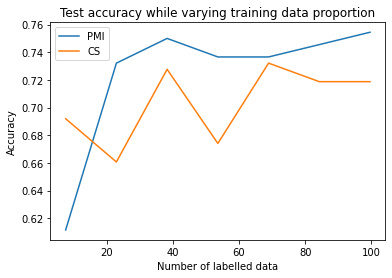

In [ ]:
untrained_accuracy_by_labeled_size_CS = []
untrained_accuracy_by_labeled_size = []
for labeled_data_size in np.arange(1, 15, 2)/100:
    untrained_accuracy_CS = load_pickle(filename=f'eval_test_model_{labeled_data_size}_CS_n1.pkl', dir='save')
    untrained_accuracy_CS = [acc[1] for acc in untrained_accuracy_CS]
    untrained_accuracy_by_labeled_size_CS.append(max(untrained_accuracy_CS))
    untrained_accuracy = load_pickle(filename=f'eval_test_model_{labeled_data_size}_PMI_n1.pkl', dir='save')
    untrained_accuracy = [acc[1] for acc in untrained_accuracy]
    untrained_accuracy_by_labeled_size.append(max(untrained_accuracy))
    
plt.plot(np.arange(1, 15, 2)/100 *len(doc_name_list), untrained_accuracy_by_labeled_size, label = "PMI")
plt.plot(np.arange(1, 15, 2)/100 *len(doc_name_list) , untrained_accuracy_by_labeled_size_CS, label = "CS")
plt.legend()
plt.title("Test accuracy while varying training data proportion")
plt.xlabel("Number of labelled data")
plt.ylabel("Accuracy")
plt.show();

## Expériences sur la part de données labélisée et comparaison entre cosine similarity et PMI avec un dataset de seulement 1% 

In [ ]:
for labeled_data_size in np.arange(10, 41, 10)/100: #[0.01, 0.05, 0.1, 0.2]:
    print("Training", labeled_data_size)
    train_subset_ids, train_subset_labels, _ = prepare_dataset(shuffle_doc_train_list, shuffle_doc_train_content_list, labeled_data_size)
    _,_,_,evaluation_untrained_CS = train(G_CS, A_hat_CS, selected=train_subset_ids, labels_selected=train_subset_labels, not_selected=test_ids, labels_not_selected=test_labels, num_classes=8, labeled_data_size=labeled_data_size, method = "CS")
    _,_,_,evaluation_untrained = train(G, A_hat, selected=train_subset_ids, labels_selected=train_subset_labels, not_selected=test_ids, labels_not_selected=test_labels, num_classes=8, labeled_data_size=labeled_data_size, method = "PMI")

    print("Untrained accuracy :", evaluation_untrained[-1], evaluation_untrained_CS[-1])

Training 0.1
Untrained accuracy : (51, 0.546875) (61, 0.53125)
Training 0.2
Untrained accuracy : (51, 0.640625) (51, 0.59375)
Training 0.3
Untrained accuracy : (51, 0.65625) (83, 0.65625)
Training 0.4
Untrained accuracy : (61, 0.75) (71, 0.703125)


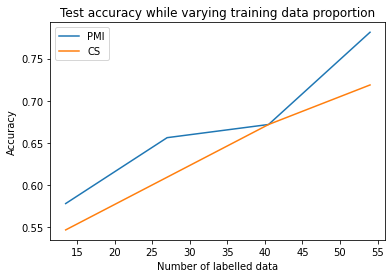

In [ ]:
untrained_accuracy_by_labeled_size_CS = []
untrained_accuracy_by_labeled_size = []
for labeled_data_size in np.arange(10, 41, 10)/100:
    untrained_accuracy_CS = load_pickle(filename=f'eval_test_model_{labeled_data_size}_CS_n2.pkl', dir='save')
    untrained_accuracy_CS = [acc[1] for acc in untrained_accuracy_CS]
    untrained_accuracy_by_labeled_size_CS.append(max(untrained_accuracy_CS))
    untrained_accuracy = load_pickle(filename=f'eval_test_model_{labeled_data_size}_PMI_n2.pkl', dir='save')
    untrained_accuracy = [acc[1] for acc in untrained_accuracy]
    untrained_accuracy_by_labeled_size.append(max(untrained_accuracy))
    
plt.plot(np.arange(10, 41, 10)/100 *len(train_ids) , untrained_accuracy_by_labeled_size, label = "PMI")
plt.plot(np.arange(10, 41, 10)/100 *len(train_ids), untrained_accuracy_by_labeled_size_CS, label = "CS")
plt.legend()
plt.title("Test accuracy while varying training data proportion")
plt.xlabel("Number of labelled data")
plt.ylabel("Accuracy")
plt.show();